# Sander van de Kamp
#### 500734351 
#### 20/05/2021
# Auto Encoder

Deze opdracht heb ik 3 keer opnieuw moeten maken omdat visual code besloot het bestand niet op te willen slaan, bestand was kennelijk corrupt dus heb een nieuwe moeten maken voordat het kon opslaan en mist misschien een paar dingen:).

---

Een auto encoder bestaat uit een `Encoder` en een `Decoder`, de `encoder` wordt gebruikt om afbeeldingen te classificeren als een schatting welk getal het is, terwijl de `decoder` gebruikt wordt om deze schatting weer terug te zetten tot het oorspronkelijke getal. Deze twee modellen worden tegelijk samen getrained, aangezien de `encoder` moet gokken welk getal het is en de `decoder` moet leren hoe deze de getallen weer terug kan zetten tot de oorspronkelijke afbeelding.

Het doel van dit bestand is om de mnist dataset van hand geschreven 28x28 zwart wit afbeeldingen van getalen door middel van een auto encoder te kunnen classificeren en nieuwe "handgeschreven" getallen te kunnen genereren.


In [14]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.optimizers import Adam
from keras.datasets import mnist
from keras.models import Model
from keras import backend as K

import numpy as np

## Data voorbereiden


In [15]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
    
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

# afbeeldingen zijn allemaal 28 x 28
input_dim = (28, 28, 1)
z_dim = 2

## Encoder

In [16]:
encoder_input = Input(input_dim, name = 'encoder_input')

x = Conv2D(filters = 32, kernel_size = 3, padding = 'same', name = 'enc_conv_1')(encoder_input)
x = LeakyReLU()(x)
x = Conv2D(filters = 64, kernel_size = 3, strides = (2,2), padding = 'same', name = 'enc_conv_2')(x)
x = LeakyReLU()(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = (2,2), padding = 'same', name = 'enc_conv_3')(x)
x = LeakyReLU()(x)

shape_before_flattening = K.int_shape(x)[1:]

x = Flatten()(x)

encoder_output = Dense(z_dim, name = 'encoder_output')(x)
encoder = Model(encoder_input, encoder_output)
encoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
enc_conv_1 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 28, 28, 32)        0         
_________________________________________________________________
enc_conv_2 (Conv2D)          (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
enc_conv_3 (Conv2D)          (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 7, 7, 128)         0   

## Decoder

In [17]:
decoder_input = Input((z_dim,), name = 'decoder_input')

x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x) # van een dense vector naar de vorm van een afbeelding

x = Conv2DTranspose(filters = 128, kernel_size = 3, padding = 'same', name = 'dec_conv_1')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters = 64, kernel_size = 3, strides = (2,2), padding = 'same', name = 'dec_conv_2')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters = 32, kernel_size = 3, strides = (2,2), padding = 'same', name = 'dec_conv_3')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters = 1, kernel_size = 3, padding = 'same', name = 'dec_conv_4')(x)
x = LeakyReLU()(x)

decoder_output = Activation('sigmoid')(x)
decoder = Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6272)              18816     
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
dec_conv_1 (Conv2DTranspose) (None, 7, 7, 128)         147584    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dec_conv_2 (Conv2DTranspose) (None, 14, 14, 64)        73792     
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 14, 14, 64)        0   

## De volledige autoencoder
De `decoder` wordt hier achter de `encoder` geplakt, waardoor het model getraint wordt om afbeeldingen af te breken en weer op te bouwen

In [18]:
autoencoder = Model(encoder_input, decoder(encoder_output))
subset = 3000

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

autoencoder.compile(optimizer = Adam(learning_rate = 0.001), loss = r_loss)
autoencoder.fit(x = x_train[:subset], y = x_train[:subset], batch_size = 32, epochs = 25, shuffle = True)

Epoch 1/25
94/94 [==============================] - 12s 97ms/step - loss: 0.1619
Epoch 2/25
94/94 [==============================] - 11s 116ms/step - loss: 0.0652
Epoch 3/25
94/94 [==============================] - 11s 116ms/step - loss: 0.0564
Epoch 4/25
94/94 [==============================] - 11s 112ms/step - loss: 0.0543
Epoch 5/25
94/94 [==============================] - 11s 114ms/step - loss: 0.0528
Epoch 6/25
94/94 [==============================] - 11s 115ms/step - loss: 0.0503
Epoch 7/25
94/94 [==============================] - 11s 115ms/step - loss: 0.0502
Epoch 8/25
94/94 [==============================] - 11s 113ms/step - loss: 0.0492
Epoch 9/25
94/94 [==============================] - 12s 130ms/step - loss: 0.0488
Epoch 10/25
94/94 [==============================] - 11s 112ms/step - loss: 0.0477
Epoch 11/25
94/94 [==============================] - 11s 115ms/step - loss: 0.0472
Epoch 12/25
94/94 [==============================] - 11s 114ms/step - loss: 0.0470
Epoch 13/25
94

## Reconstructie van originele afbeeldingen

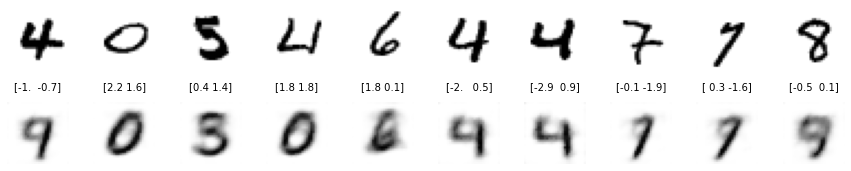

In [19]:
import matplotlib.pyplot as plt

n = 10

# selecteer willekeurige afbeeldingen uit x_test
idx = np.random.choice(range(len(x_test)), n)
test_images = x_test[idx]

# vertaal met de encoder naar getallen
z_points = encoder.predict(test_images)

# vertaal de getallen met de decoder terug naar afbeeldingen
reconstr_images = decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n):
    img = test_images[i].reshape((28,28))
    ax = fig.add_subplot(2, n, i + 1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)   
    ax.imshow(img, cmap='gray_r')
    
for i in range(n):
    img = reconstr_images[i].reshape((28,28))
    ax = fig.add_subplot(2, n, i + n + 1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')

Alles wat door de decoder gemaakt wordt is erg wazig en het enige dat duidelijk te zien is zijn de delen die altijd hetzelfde zijn, zoals het onderste deel van de 9 en de 4 of de 1 zelf.
## Plot van de encoder outputs
Hierop is te zien welke getallen de `encoder` vind, waar de `decoder` op getraint wordt om weer te reconstrueren.

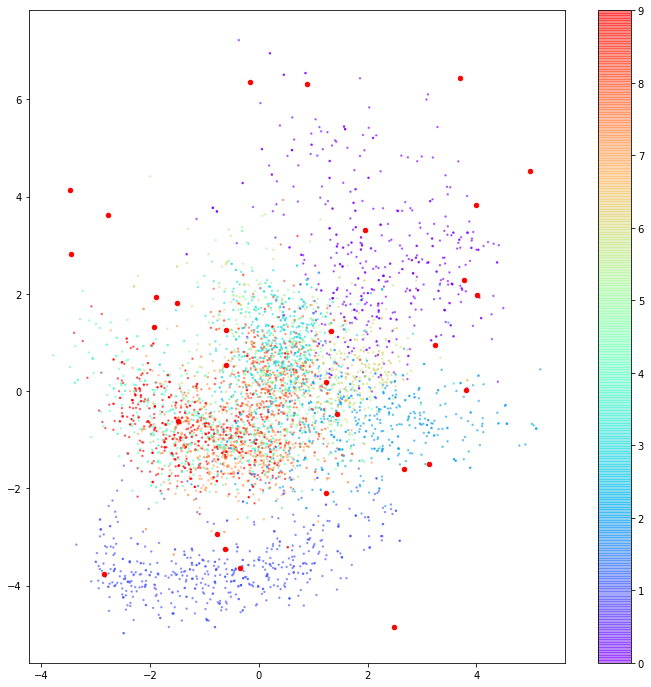

In [20]:
n = 5000
grid_size = 10
grid_depth = 3
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n)
test_images = x_test[example_idx]
test_labels = y_test[example_idx]

z_points = encoder.predict(test_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize = (figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap = 'rainbow' , c = test_labels, alpha = 0.5, s = 2)
plt.colorbar()

# willekeurige punten
x = np.random.uniform(min_x,max_x, size = grid_size * grid_depth)
y = np.random.uniform(min_y,max_y, size = grid_size * grid_depth)
z_grid = np.array(list(zip(x, y)))

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
plt.show()

## Reconstructie van originele afbeeldingen

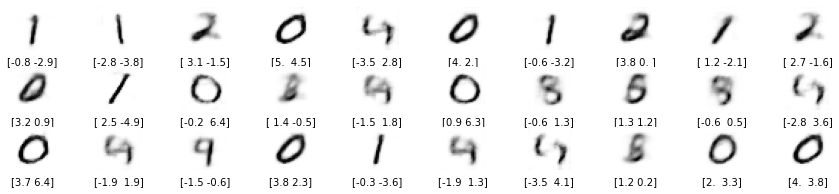

In [21]:
reconst = decoder.predict(z_grid)

figsize = 15
fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

De getallen zijn meestal wazig behalve de 1 en 0, de rest van de getallen zijn nogsteeds wel redelijk te onderschijden alleen zijn ze redelijk wazig. dit komt dan ook doordat er veel overlap zit in de outputs van de encoder.

---

# Evaluatie

Eerst kreeg ik het model niet werkend op de functionele methode en dat lag kennelijk aan het feit dat ik de naamgeving van de lagen niet bij had gegeven, als deze niet toegevoegd worden dan traint het model alleen maar 1 laag van de `encoder` en de `decoder` waardoor alle output wit blijft.

Het model simpler maken werkt ook niet aangezien het opbouwen van een afbeelding met maar twee lagen te wazig wordt om een volledige afbeelding te hebben, ook is de output van de decoder slechter verspreid waardoor de afbeeldingen ook waziger worden. Hierom moeten de encoder en decoder beide niet simpler gemaakt worden. de slechtere encoder zorgt er ook voor dat de cluster van verschillende getallen in het middel nog meer op elkaar gedrukt wordt, waardoor de decoder nog minder er van kan maken.

Bij het toevoegen van een normalisatielaag wordt de output van de encoder beter verspreid, dit zorgt ervoor dat de decoder minder plekken heeft waar het geen voorbeelden van heeft gehad. Hierdoor wordt de output minder wazig en wordt de cluster van getallen in het midden ook beter verspreid.

---

Namen toevoegen voor de functionele methode is essentieel en het model werkt anders niet, het genereren en classificeren van modellen is geen simpel werk dus is het beter om meerdere lagen te gebruiken en normalisatielagen werken goed om te zorgen dat de outputs beter verspreid zijn.

---

## Simpler model

In [31]:
encoder_input = Input(input_dim, name = 'encoder_input')

x = Conv2D(filters = 16, kernel_size = 3, padding = 'same', name = 'enc_conv_1')(encoder_input)
x = LeakyReLU()(x)
x = Conv2D(filters = 32, kernel_size = 3, strides = (2,2), padding = 'same', name = 'enc_conv_2')(x)
x = LeakyReLU()(x)

shape_before_flattening = K.int_shape(x)[1:]

x = Flatten()(x)

encoder_output = Dense(z_dim, name = 'encoder_output')(x)
encoder = Model(encoder_input, encoder_output)

In [32]:
decoder_input = Input((z_dim,), name = 'decoder_input')

x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x) # van een dense vector naar de vorm van een afbeelding

x = Conv2DTranspose(filters = 32, kernel_size = 3, padding = 'same', name = 'dec_conv_2')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters = 16, kernel_size = 3, strides = (2,2), padding = 'same', name = 'dec_conv_3')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters = 1, kernel_size = 3, padding = 'same', name = 'dec_conv_4')(x)
x = LeakyReLU()(x)

decoder_output = Activation('sigmoid')(x)
decoder = Model(decoder_input, decoder_output)

In [33]:
autoencoder = Model(encoder_input, decoder(encoder_output))
subset = 3000

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

autoencoder.compile(optimizer = Adam(learning_rate = 0.001), loss = r_loss)
autoencoder.fit(x = x_train[:subset], y = x_train[:subset], batch_size = 32, epochs = 25, shuffle = True)

Epoch 1/25
94/94 [==============================] - 7s 47ms/step - loss: 0.1542
Epoch 2/25
94/94 [==============================] - 4s 48ms/step - loss: 0.0652
Epoch 3/25
94/94 [==============================] - 5s 50ms/step - loss: 0.0580
Epoch 4/25
94/94 [==============================] - 5s 48ms/step - loss: 0.0563
Epoch 5/25
94/94 [==============================] - 5s 51ms/step - loss: 0.0564
Epoch 6/25
94/94 [==============================] - 5s 49ms/step - loss: 0.0556
Epoch 7/25
94/94 [==============================] - 5s 52ms/step - loss: 0.0539
Epoch 8/25
94/94 [==============================] - 5s 57ms/step - loss: 0.0535
Epoch 9/25
94/94 [==============================] - 5s 52ms/step - loss: 0.0539
Epoch 10/25
94/94 [==============================] - 5s 54ms/step - loss: 0.0523
Epoch 11/25
94/94 [==============================] - 5s 52ms/step - loss: 0.0517
Epoch 12/25
94/94 [==============================] - 5s 53ms/step - loss: 0.0513
Epoch 13/25
94/94 [==================

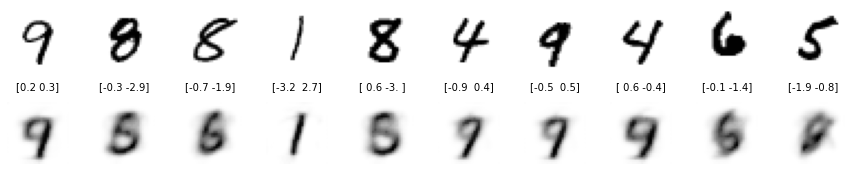

In [29]:
import matplotlib.pyplot as plt

n = 10

# selecteer willekeurige afbeeldingen uit x_test
idx = np.random.choice(range(len(x_test)), n)
test_images = x_test[idx]

# vertaal met de encoder naar getallen
z_points = encoder.predict(test_images)

# vertaal de getallen met de decoder terug naar afbeeldingen
reconstr_images = decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n):
    img = test_images[i].reshape((28,28))
    ax = fig.add_subplot(2, n, i + 1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)   
    ax.imshow(img, cmap='gray_r')
    
for i in range(n):
    img = reconstr_images[i].reshape((28,28))
    ax = fig.add_subplot(2, n, i + n + 1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')

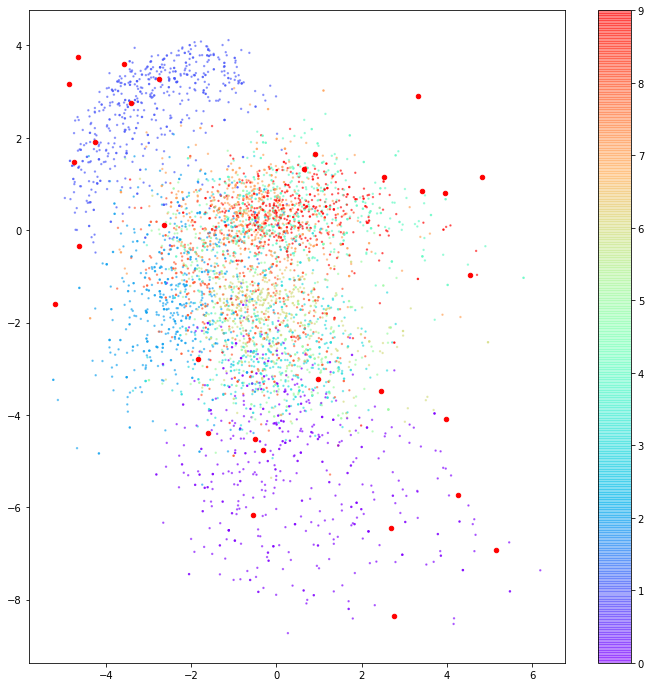

In [30]:
n = 5000
grid_size = 10
grid_depth = 3
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n)
test_images = x_test[example_idx]
test_labels = y_test[example_idx]

z_points = encoder.predict(test_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize = (figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap = 'rainbow' , c = test_labels, alpha = 0.5, s = 2)
plt.colorbar()

# willekeurige punten
x = np.random.uniform(min_x,max_x, size = grid_size * grid_depth)
y = np.random.uniform(min_y,max_y, size = grid_size * grid_depth)
z_grid = np.array(list(zip(x, y)))

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
plt.show()

---
# model met normalisatie laag

In [38]:
encoder_input = Input(input_dim, name = 'encoder_input')

x = Conv2D(filters = 32, kernel_size = 3, padding = 'same', name = 'enc_conv_1')(encoder_input)
x = LeakyReLU()(x)
x = Conv2D(filters = 64, kernel_size = 3, strides = (2,2), padding = 'same', name = 'enc_conv_2')(x)
x = LeakyReLU()(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = (2,2), padding = 'same', name = 'enc_conv_3')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)

shape_before_flattening = K.int_shape(x)[1:]

x = Flatten()(x)

encoder_output = Dense(z_dim, name = 'encoder_output')(x)
encoder = Model(encoder_input, encoder_output)

In [39]:
decoder_input = Input((z_dim,), name = 'decoder_input')

x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x) # van een dense vector naar de vorm van een afbeelding

x = Conv2DTranspose(filters = 128, kernel_size = 3, padding = 'same', name = 'dec_conv_1')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters = 64, kernel_size = 3, strides = (2,2), padding = 'same', name = 'dec_conv_2')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters = 32, kernel_size = 3, strides = (2,2), padding = 'same', name = 'dec_conv_3')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(filters = 1, kernel_size = 3, padding = 'same', name = 'dec_conv_4')(x)
x = LeakyReLU()(x)

decoder_output = Activation('sigmoid')(x)
decoder = Model(decoder_input, decoder_output)

In [40]:
autoencoder = Model(encoder_input, decoder(encoder_output))
subset = 3000

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

autoencoder.compile(optimizer = Adam(learning_rate = 0.001), loss = r_loss)
autoencoder.fit(x = x_train[:subset], y = x_train[:subset], batch_size = 32, epochs = 25, shuffle = True)

Epoch 1/25
94/94 [==============================] - 15s 105ms/step - loss: 0.1211
Epoch 2/25
94/94 [==============================] - 9s 99ms/step - loss: 0.0590
Epoch 3/25
94/94 [==============================] - 10s 102ms/step - loss: 0.0576
Epoch 4/25
94/94 [==============================] - 9s 92ms/step - loss: 0.0560
Epoch 5/25
94/94 [==============================] - 8s 90ms/step - loss: 0.0554
Epoch 6/25
94/94 [==============================] - 8s 87ms/step - loss: 0.0546
Epoch 7/25
94/94 [==============================] - 8s 81ms/step - loss: 0.0536
Epoch 8/25
94/94 [==============================] - 8s 81ms/step - loss: 0.0532
Epoch 9/25
94/94 [==============================] - 8s 85ms/step - loss: 0.0522
Epoch 10/25
94/94 [==============================] - 10s 106ms/step - loss: 0.0515
Epoch 11/25
94/94 [==============================] - 10s 106ms/step - loss: 0.0511
Epoch 12/25
94/94 [==============================] - 11s 112ms/step - loss: 0.0512
Epoch 13/25
94/94 [========

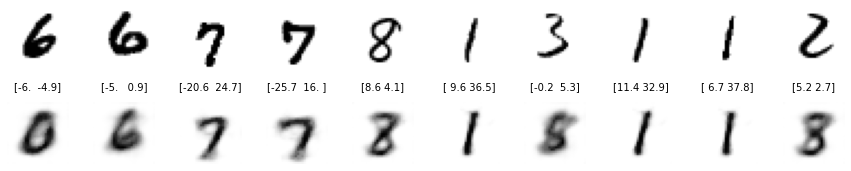

In [43]:
import matplotlib.pyplot as plt

n = 10

# selecteer willekeurige afbeeldingen uit x_test
idx = np.random.choice(range(len(x_test)), n)
test_images = x_test[idx]

# vertaal met de encoder naar getallen
z_points = encoder.predict(test_images)

# vertaal de getallen met de decoder terug naar afbeeldingen
reconstr_images = decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n):
    img = test_images[i].reshape((28,28))
    ax = fig.add_subplot(2, n, i + 1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)   
    ax.imshow(img, cmap='gray_r')
    
for i in range(n):
    img = reconstr_images[i].reshape((28,28))
    ax = fig.add_subplot(2, n, i + n + 1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')

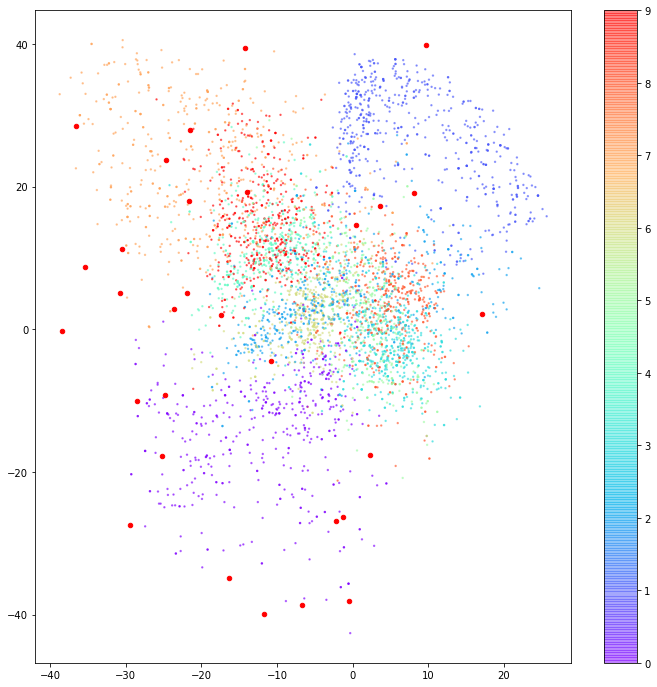

In [42]:
n = 5000
grid_size = 10
grid_depth = 3
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n)
test_images = x_test[example_idx]
test_labels = y_test[example_idx]

z_points = encoder.predict(test_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize = (figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap = 'rainbow' , c = test_labels, alpha = 0.5, s = 2)
plt.colorbar()

# willekeurige punten
x = np.random.uniform(min_x,max_x, size = grid_size * grid_depth)
y = np.random.uniform(min_y,max_y, size = grid_size * grid_depth)
z_grid = np.array(list(zip(x, y)))

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
plt.show()